In [29]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing import image

from plot_keras_history import show_history, plot_history

import tensorflow as tf

# For normalization and preparation
import cv2
from skimage.exposure import match_histograms
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

#For tiling
from PIL import Image

# Première approche: images non préparées

## Data augmentation

In [30]:
# Définir les chemins vers les répertoires d'entraînement et de validation
TRAIN_DIR = "../data/train"
VAL_DIR = "../data/validation"

# Créer un générateur d'images sans augmentation de données
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Charger les images depuis le répertoire
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 21 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


## Visualisation d'images

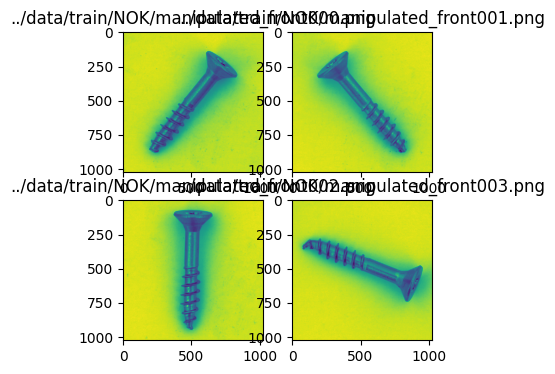

In [31]:
# Visualisons quelques images
fig, ax = plt.subplots(2,2,figsize=(4,4))
k = 0
for i in range(2):
    for j in range(2):
        image_path = str(os.listdir(os.path.join(TRAIN_DIR,"NOK"))[k])
        image_path = TRAIN_DIR + r"/NOK/" + image_path
        ax[i][j].imshow(plt.imread(image_path))
        ax[i][j].set_title(image_path)
        k += 1

## Instanciation et entraînement du modèle

In [32]:
# Charger le modèle VGG16 sans les couches supérieures (top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congeler les couches de base (optionnel)
for layer in base_model.layers:
    layer.trainable = False

In [33]:
# Ajouter des couches personnalisées pour la classification
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
1/1 [==============================] - 9s 9s/step - loss: 0.7258 - accuracy: 0.4762 - val_loss: 2.2354 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 8s 8s/step - loss: 0.9575 - accuracy: 0.7619 - val_loss: 2.2263 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 7s 7s/step - loss: 0.8811 - accuracy: 0.7619 - val_loss: 1.6434 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 7s 7s/step - loss: 0.5740 - accuracy: 0.7619 - val_loss: 1.0352 - val_accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 7s 7s/step - loss: 0.3774 - accuracy: 0.8571 - val_loss: 0.7980 - val_accuracy: 0.2500


## Evaluation du modèle

In [34]:
# Évaluer le modèle
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

# Sauvegarder le modèle
model.save("../models/model.h5")

1/1 [==============================] - 2s 2s/step - loss: 0.7980 - accuracy: 0.2500
Validation Loss: 0.7980266213417053
Validation Accuracy: 0.25


## Prédiction des images

In [53]:
image_dir = TRAIN_DIR + r"/OK"
for image_path in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_path)
    img = image.load_img(image_path, target_size=(224, 224))  # Assurez-vous que la taille correspond à celle attendue par votre modèle
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
    img_array = img_array / 255.0  # Normaliser les pixels
    prediction = model.predict(img_array)
    print(f"Prédiction pour {image_path}: {np.argmax(prediction)}")    

1/1 [==============================] - 0s 304ms/step
Prédiction pour ../data/train/OK\ok188.png: 1
1/1 [==============================] - 0s 309ms/step
Prédiction pour ../data/train/OK\ok189.png: 1
1/1 [==============================] - 0s 316ms/step
Prédiction pour ../data/train/OK\ok190.png: 0
1/1 [==============================] - 0s 304ms/step
Prédiction pour ../data/train/OK\ok191.png: 0
1/1 [==============================] - 0s 316ms/step
Prédiction pour ../data/train/OK\ok192.png: 1
1/1 [==============================] - 0s 298ms/step
Prédiction pour ../data/train/OK\ok193.png: 1
1/1 [==============================] - 0s 302ms/step
Prédiction pour ../data/train/OK\ok194.png: 1
1/1 [==============================] - 0s 306ms/step
Prédiction pour ../data/train/OK\ok195.png: 1
1/1 [==============================] - 0s 304ms/step
Prédiction pour ../data/train/OK\ok196.png: 1
1/1 [==============================] - 0s 306ms/step
Prédiction pour ../data/train/OK\ok197.png: 1
1/1 [=====

# Deuxième approche: images préparées

## Création de nouveaux dossiers d'entraînement et de validation avec les images préparées

In [37]:
img = plt.imread(r"C:\Users\John\Desktop\LFP\data\train\OK\ok188.png")
taille_img = img.shape
taille_img

(1024, 1024)

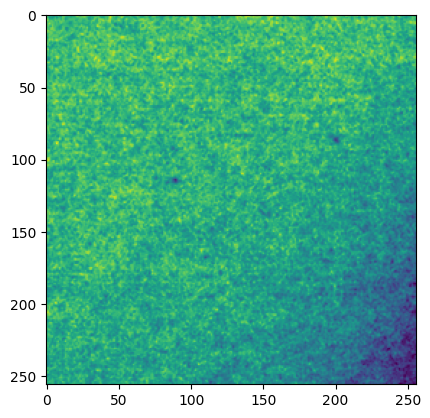

In [38]:
y_start, y_end = 0, int(taille_img[0]/4)
x_start, x_end = int(taille_img[1]/4), int(taille_img[1]/2)
img_cropped = img[y_start:y_end, x_start:x_end]
plt.imshow(img_cropped)

In [39]:
#crée un dossier dir_crop à partir du dossier dir avec des sous dossiers "OK" et "NOK" qui reprend les images de dir en les réduisant
def preparation_image(dir, dir_crop):
    for img in os.listdir(os.path.join(dir,"OK")):
        # Load the image
        image_path = dir + r"/OK/" + img
        image = cv2.imread(image_path)
        
        # Define the coordinates of the top-left corner and the bottom-right corner of the window
        #x_start, y_start = 50, 50  # Top-left corner
        #x_end, y_end = 200, 200    # Bottom-right corner
        
        # Crop the window
        cropped_image = image[y_start:y_end, x_start:x_end]
    
        # Créer le dossier s'il n'existe pas
        dossier = dir_crop + r"/OK"
        os.makedirs(dossier, exist_ok=True)
        
        # Chemin d'accès pour sauvegarder l'image préparée
        cropped_image_path = os.path.join(dossier, img)
        
        # Sauvegarder l'image au même nom que l'image d'origine
        cv2.imwrite(cropped_image_path, cropped_image)

    for img in os.listdir(os.path.join(dir,"NOK")):
        # Load the image
        image_path = dir + r"/NOK/" + img
        image = cv2.imread(image_path)
        
        # Define the coordinates of the top-left corner and the bottom-right corner of the window
        #x_start, y_start = 50, 50  # Top-left corner
        #x_end, y_end = 200, 200    # Bottom-right corner
        
        # Crop the window
        cropped_image = image[y_start:y_end, x_start:x_end]
    
        # Créer le dossier s'il n'existe pas
        dossier = dir_crop + r"/NOK"
        os.makedirs(dossier, exist_ok=True)
        
        # Chemin d'accès pour sauvegarder l'image préparée
        cropped_image_path = os.path.join(dossier, img)
        
        # Sauvegarder l'image au même nom que l'image d'origine
        cv2.imwrite(cropped_image_path, cropped_image)

In [40]:
# Définir les chemins vers les répertoires d'entraînement et de validation
TRAIN_DIR_CROP = "../data/crop/train"
VAL_DIR_CROP = "../data/crop/validation"

preparation_image(TRAIN_DIR, TRAIN_DIR_CROP)
preparation_image(VAL_DIR, VAL_DIR_CROP)

## Augmentation des données

In [41]:
# Créer un générateur d'images sans augmentation de données
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Charger les images depuis le répertoire
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR_CROP,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR_CROP,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 21 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


## Instanciation et entraînement du modèle

In [42]:
# Ajouter des couches personnalisées pour la classification
model_crop = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compiler le modèle
model_crop.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
model_crop.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
1/1 [==============================] - 9s 9s/step - loss: 0.6251 - accuracy: 0.7143 - val_loss: 1.6878 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 7s 7s/step - loss: 0.7659 - accuracy: 0.7619 - val_loss: 1.5670 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 7s 7s/step - loss: 0.6655 - accuracy: 0.7619 - val_loss: 1.1150 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 7s 7s/step - loss: 0.4752 - accuracy: 0.7619 - val_loss: 0.8435 - val_accuracy: 0.3750
Epoch 5/5
1/1 [==============================] - 7s 7s/step - loss: 0.5231 - accuracy: 0.8095 - val_loss: 0.8468 - val_accuracy: 0.3750


## Evaluation du modèle

In [44]:
# Évaluer le modèle
loss, accuracy = model_crop.evaluate(val_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

# Sauvegarder le modèle
model_crop.save("../models/model_crop.h5")

1/1 [==============================] - 2s 2s/step - loss: 0.8468 - accuracy: 0.3750
Validation Loss: 0.8467689752578735
Validation Accuracy: 0.375


In [ ]:
image_dir = TRAIN_DIR + r"/OK"
for image_path in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_path)
    img = image.load_img(image_path, target_size=(224, 224))  # Assurez-vous que la taille correspond à celle attendue par votre modèle
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
    img_array = img_array / 255.0  # Normaliser les pixels
    prediction = model_crop.predict(img_array)
    print(f"Prédiction pour {image_path}: {np.argmax(prediction)}")    